## Does R&D Spending Improve Revenue for Companies?

In [1]:
#Packages
import pandas as pd
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
import statsmodels.api as sm
from sklearn.cluster import KMeans

### Data Preparation

#### Pull Data - API

In [2]:
# Header to pull API
headers = {'User-Agent': 'DSC680-project'}

In [3]:
# Needed data
metrics = {'Revenue': 'Revenues',
           'R&D': 'ResearchAndDevelopmentExpense',
           'Net_Income': 'NetIncomeLoss'}

In [4]:
# Range
years = range(2008, 2023) 

In [5]:
# Empty dictionary
data = {}

In [6]:
# For loop to download each metric
for label, metric in metrics.items():
    # Empty list for each row
    rows = []
    
    
    # For loop to download each year for each company
    for year in years:
        # API - Change link for each matric and year
        url = f'https://data.sec.gov/api/xbrl/frames/us-gaap/{metric}/USD/CY{year}.json'
        # Request API
        response = requests.get(url, headers=headers)
        
        
        # Make sure request worked
        if response.status_code == 200:
            # Make webdata into dict
            data_pull = response.json()
            # Pull general account info for each company
            data_pull = data_pull['data']
            
            
            # For loop to store each company for each year
            for entry in data_pull:
                # Store only the wanted data
                rows.append({
                    # Company ID
                    'Company_ID': entry.get('cik'),
                    # Company Name
                    'Company_Name': entry.get('entityName'),
                    # Year
                    'Year': year,
                    # Metrics
                    label: entry.get('val'),
                    # Date it was filled
                    'Filing_Date': entry.get('end')})
        else:
            # Print Failer notice if it does not work
            print("Failed to retrieve")
    # Add
    time.sleep(0.15)
    
    # Make all metrics into data frames
    data[label] = pd.DataFrame(rows)

In [7]:
# Merge all three metrics into one dataframe
data_1 = data['Revenue'].merge(
    data['R&D'], on=['Company_ID', 'Company_Name', 'Year', 'Filing_Date'], 
    how='outer').merge(data['Net_Income'], on=['Company_ID', 'Company_Name', 
                                               'Year', 'Filing_Date'], how='outer')

In [8]:
data_1

,Company_ID,Company_Name,Year,Revenue,Filing_Date,R&D,Net_Income
0,864328,BJ SERVICES CO,2008,5.359077e+09,2008-09-30,7.199700e+07,6.093650e+08
1,64978,MERCK SHARP & DOHME CORP.,2008,2.385030e+10,2008-12-31,4.805300e+09,7.808400e+09
2,1335793,CNX GAS CORP,2008,7.894210e+08,2008-12-31,NaN,2.390730e+08
3,868809,XTO ENERGY INC,2008,7.695000e+09,2008-12-31,NaN,1.912000e+09
4,1094316,TRINTECH GROUP PLC,2008,3.966400e+07,2009-01-31,6.069000e+06,-1.232000e+06
...,...,...,...,...,...,...,...
100402,2025410,"StandardAero, Inc.",2022,NaN,2022-12-31,NaN,-2.100000e+07
100403,2037804,New Mountain Private Credit Fund,2022,NaN,2022-12-31,NaN,4.987100e+07
100404,2040127,KARMAN HOLDINGS INC.,2022,NaN,2022-12-31,NaN,-1.409862e+07
100405,2042694,Primo Brands Corp,2022,NaN,2022-12-31,NaN,-1.267000e+08


#### Clean Data

In [9]:
# Delete and duplicates
data_1 = data_1.drop_duplicates()

In [10]:
# Remove any Revenue that is 0 to predict sales growth.
# Do not know for sure that NaN means they did not spend money 
data_2 = data_1.dropna(subset=['Revenue', 'Net_Income'])

Notes: Do not know for sure that NaN means no money was spent on R&D. After looking at SEC data it does not seemto be required. So NaN was dropped.

In [11]:
data_2

,Company_ID,Company_Name,Year,Revenue,Filing_Date,R&D,Net_Income
0,864328,BJ SERVICES CO,2008,5.359077e+09,2008-09-30,7.199700e+07,6.093650e+08
1,64978,MERCK SHARP & DOHME CORP.,2008,2.385030e+10,2008-12-31,4.805300e+09,7.808400e+09
2,1335793,CNX GAS CORP,2008,7.894210e+08,2008-12-31,NaN,2.390730e+08
3,868809,XTO ENERGY INC,2008,7.695000e+09,2008-12-31,NaN,1.912000e+09
4,1094316,TRINTECH GROUP PLC,2008,3.966400e+07,2009-01-31,6.069000e+06,-1.232000e+06
...,...,...,...,...,...,...,...
45928,2027317,Curbline Properties Corp.,2022,7.313600e+07,2022-12-31,NaN,2.573000e+07
45929,2029471,Heidmar Maritime Holdings Corp.,2022,3.006388e+07,2022-12-31,NaN,1.618095e+07
45930,2032779,EUROHOLDINGS LTD.,2022,2.448025e+07,2022-12-31,NaN,1.402452e+07
45931,2033515,TOP WIN INTERNATIONAL LIMITED,2022,1.422516e+07,2022-12-31,NaN,7.199000e+04


Notes: Large part of the data is NA. Also pull the industry because not all companies need R&D

In [12]:
# Make copy of data due to error
data_3 =  data_2.copy()

#### Unique CIKs - Pull data API

In [13]:
# Collect CIKs as a unique list
ciks = data_3['Company_ID'].astype(str).drop_duplicates().tolist()

# Empty list for each row
ciks_rows = []

In [14]:
# Need CIKs code to be able to find industry
# For loop to pull each ID
for cik in ciks:
    # Add zeros before Company ID to follow SEC format
    cik_zero = cik.zfill(10)
    #link for each company ID
    url = f'https://data.sec.gov/submissions/CIK{cik_zero}.json'
    # Header
    headers = {'User-Agent': 'DSC680-project'}  
    # Request data
    response = requests.get(url, headers=headers)
    
    
    # If everything is good, pull the wanted information 
    if response.status_code == 200:
        # Make the files readable
        ciks_data = response.json()
        ciks_rows.append({
            # Company ID, need to merge
            'Company_ID': cik.lstrip('0'),
            # Classification code for SEC
            'SIC': ciks_data.get('sic'),
            # More Specific than Industry
            'SIC_Description': ciks_data.get('sicDescription'),
            # Pull Industry
            'Industry': ciks_data.get('ownerOrg'),
            # More company size (Not sure if needed)
            'Category': ciks_data.get('category')})
    # Skip company if it does not have it
    else:
        continue
    # Prevent error
    time.sleep(0.10)

In [15]:
# Turn into DataFrame
ciks_data = pd.DataFrame(ciks_rows)

In [16]:
ciks_data

,Company_ID,SIC,SIC_Description,Industry,Category
0,864328,1389,"Oil & Gas Field Services, NEC",None,Large Accelerated
1,64978,2834,Pharmaceutical Preparations,03 Life Sciences,
2,1335793,1311,Crude Petroleum & Natural Gas,None,Large Accelerated
3,868809,1311,Crude Petroleum & Natural Gas,None,Large Accelerated
4,1094316,7372,Services-Prepackaged Software,None,
...,...,...,...,...,...
7508,2027317,6500,Real Estate,05 Real Estate & Construction,<br>Emerging growth company
7509,2029471,4412,Deep Sea Foreign Transportation of Freight,01 Energy & Transportation,Non-accelerated filer<br>Emerging growth company
7510,2032779,4412,Deep Sea Foreign Transportation of Freight,01 Energy & Transportation,Non-accelerated filer<br>Emerging growth company
7511,2033515,5094,"Wholesale-Jewelry, Watches, Precious Stones & ...",07 Trade & Services,Non-accelerated filer<br>Emerging growth company


In [17]:
# Make sure both Company_ID is a str
data_3['Company_ID'] = data_3['Company_ID'].astype(str)
ciks_data['Company_ID'] = ciks_data['Company_ID'].astype(str)

In [18]:
# Merge on Company_ID
data_4 = pd.merge(data_3, ciks_data, on='Company_ID', how='left')

In [19]:
data_4

,Company_ID,Company_Name,Year,Revenue,Filing_Date,R&D,Net_Income,SIC,SIC_Description,Industry,Category
0,864328,BJ SERVICES CO,2008,5.359077e+09,2008-09-30,7.199700e+07,6.093650e+08,1389,"Oil & Gas Field Services, NEC",None,Large Accelerated
1,64978,MERCK SHARP & DOHME CORP.,2008,2.385030e+10,2008-12-31,4.805300e+09,7.808400e+09,2834,Pharmaceutical Preparations,03 Life Sciences,
2,1335793,CNX GAS CORP,2008,7.894210e+08,2008-12-31,NaN,2.390730e+08,1311,Crude Petroleum & Natural Gas,None,Large Accelerated
3,868809,XTO ENERGY INC,2008,7.695000e+09,2008-12-31,NaN,1.912000e+09,1311,Crude Petroleum & Natural Gas,None,Large Accelerated
4,1094316,TRINTECH GROUP PLC,2008,3.966400e+07,2009-01-31,6.069000e+06,-1.232000e+06,7372,Services-Prepackaged Software,None,
...,...,...,...,...,...,...,...,...,...,...,...
41956,2027317,Curbline Properties Corp.,2022,7.313600e+07,2022-12-31,NaN,2.573000e+07,6500,Real Estate,05 Real Estate & Construction,<br>Emerging growth company
41957,2029471,Heidmar Maritime Holdings Corp.,2022,3.006388e+07,2022-12-31,NaN,1.618095e+07,4412,Deep Sea Foreign Transportation of Freight,01 Energy & Transportation,Non-accelerated filer<br>Emerging growth company
41958,2032779,EUROHOLDINGS LTD.,2022,2.448025e+07,2022-12-31,NaN,1.402452e+07,4412,Deep Sea Foreign Transportation of Freight,01 Energy & Transportation,Non-accelerated filer<br>Emerging growth company
41959,2033515,TOP WIN INTERNATIONAL LIMITED,2022,1.422516e+07,2022-12-31,NaN,7.199000e+04,5094,"Wholesale-Jewelry, Watches, Precious Stones & ...",07 Trade & Services,Non-accelerated filer<br>Emerging growth company


In [20]:
print(data_4.isna().sum())

Company_ID             0
Company_Name           0
Year                   0
Revenue                0
Filing_Date            0
R&D                27937
Net_Income             0
SIC                    0
SIC_Description        0
Industry           15061
Category               0
dtype: int64


Notes: A lot of Industry are missing. Add Industry. No file found. Make a table. Links below to find information

### Make Industry Dataset

In [21]:
# SIC Division
sic_divisions = [
    {"Division": "A", "Name": "Agriculture, Forestry, and Fishing", "Start": 100, "End": 999},
    {"Division": "B", "Name": "Mining", "Start": 1000, "End": 1499},
    {"Division": "C", "Name": "Construction", "Start": 1500, "End": 1799},
    {"Division": "D", "Name": "Manufacturing", "Start": 2000, "End": 3999},
    {"Division": "E", "Name": "Transportation, Communications, Electric, Gas & Sanitary", "Start": 4000, "End": 4999},
    {"Division": "F", "Name": "Wholesale Trade", "Start": 5000, "End": 5199},
    {"Division": "G", "Name": "Retail Trade", "Start": 5200, "End": 5999},
    {"Division": "H", "Name": "Finance, Insurance & Real Estate", "Start": 6000, "End": 6799},
    {"Division": "I", "Name": "Services", "Start": 7000, "End": 8999},
    {"Division": "J", "Name": "Public Administration", "Start": 9100, "End": 9729},
    {"Division": "-", "Name": "Nonclassifiable Establishments", "Start": 9900, "End": 9999}]

Links: <br>
https://www.naics.com/sic-codes-industry-drilldown/, <br>
https://siccode.com/sic-code-lookup-directory, <br>
https://fieldtexcases.com/blog/manufacturing-sic-codes/?utm_source=chatgpt.com

In [22]:
# Make a funcation to make a table of all codes
def get_division(sic):
    for d in sic_divisions:
        #only make a list between the SIC cat. codes
        if d["Start"] <= sic <= d["End"]:
            # Return results
            return d["Division"], d["Name"]
    # Give no result if it does not meet the requirements
    return None, None

In [23]:
# Funcation to make the numbers from get_division into int format 
def int_division(x):
    try:
        # Make results an int.
        x_int = int(x)
        # Return results as a pd series for dataframe
        return pd.Series(get_division(x_int))
    # If error occurs enter none
    except Exception:
        return pd.Series([None, None])

In [24]:
data_4[["SIC_Division", "SIC_Industry"]] = data_4["SIC"].apply(int_division)

In [25]:
data_4.head()

,Company_ID,Company_Name,Year,Revenue,Filing_Date,R&D,Net_Income,SIC,SIC_Description,Industry,Category,SIC_Division,SIC_Industry
0,864328,BJ SERVICES CO,2008,5.359077e+09,2008-09-30,7.199700e+07,6.093650e+08,1389,"Oil & Gas Field Services, NEC",None,Large Accelerated,B,Mining
1,64978,MERCK SHARP & DOHME CORP.,2008,2.385030e+10,2008-12-31,4.805300e+09,7.808400e+09,2834,Pharmaceutical Preparations,03 Life Sciences,,D,Manufacturing
2,1335793,CNX GAS CORP,2008,7.894210e+08,2008-12-31,NaN,2.390730e+08,1311,Crude Petroleum & Natural Gas,None,Large Accelerated,B,Mining
3,868809,XTO ENERGY INC,2008,7.695000e+09,2008-12-31,NaN,1.912000e+09,1311,Crude Petroleum & Natural Gas,None,Large Accelerated,B,Mining
4,1094316,TRINTECH GROUP PLC,2008,3.966400e+07,2009-01-31,6.069000e+06,-1.232000e+06,7372,Services-Prepackaged Software,None,,I,Services


#### Clean Data

In [69]:
# Calculate the sales growth
# sort to make the results sort each year for each company
data_5 = data_4.sort_values(['Company_ID', 'Year'])
# Make new column for sales growth for revenue
data_5['Sales_Growth'] = data_4.groupby('Company_ID')['Revenue'].pct_change()
# Make new column for sales growth for R&D
data_5['RD_Growth'] = data_4.groupby('Company_ID')['R&D'].pct_change()

In [70]:
# Check for NaN
print(data_5.isna().sum())

Company_ID             0
Company_Name           0
Year                   0
Revenue                0
Filing_Date            0
R&D                27937
Net_Income             0
SIC                    0
SIC_Description        0
Industry           15061
Category               0
SIC_Division          18
SIC_Industry          18
Sales_Growth        9348
RD_Growth          30129
dtype: int64


In [71]:
# Drop NaN
data_5 = data_5.dropna(subset=['Industry','SIC_Division', 'SIC_Industry', 'Sales_Growth'])

In [72]:
# Fil NaN with Zero
data_5['R&D'] = data_5['R&D'].fillna(0)

### Do companies that currently spend heavily on R&D achieve faster sales growth than companies spending less?

In [73]:
# Group by industry and calculate average sales growth
industry_growth = data_5.groupby('SIC_Industry')['R&D'].mean().sort_values(ascending=False)

##### Average Sales Growth by Industry

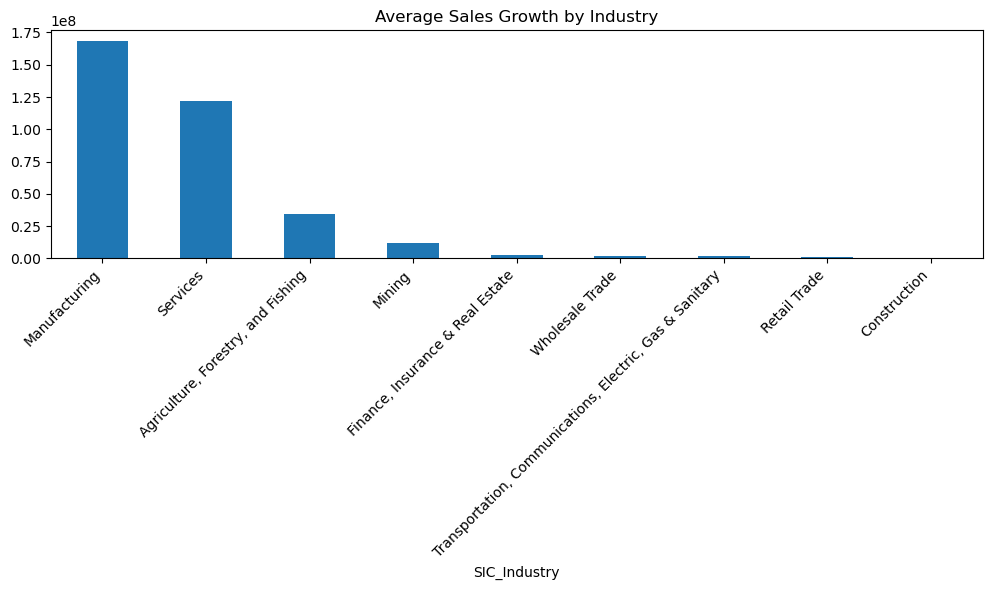

In [74]:
# Graph size
plt.figure(figsize=(10, 6))
# Make a bar chart
industry_growth.plot(kind='bar')
plt.title('Average Sales Growth by Industry')
# Make industry easy to read
plt.xticks(rotation=45, ha='right')
# Make labels print within size
plt.tight_layout()
# Print graph
plt.show()

In [75]:
# Fix error. Remove outliers
# 25% of the data Q1
Q1 = data_5['Sales_Growth'].quantile(0.25)
# 75% of the data Q3
Q3 = data_5['Sales_Growth'].quantile(0.75)
# Find the spread (IQR)
spread = Q3 - Q1

In [76]:
# find lower outliers
lower_bound = Q1 - 1.5 * spread
# Find upper outliers
upper_bound = Q3 + 1.5 * spread

In [77]:
# Filter out outliers
data_6 = data_5[(data_5['Sales_Growth'] >= lower_bound) & (data_5['Sales_Growth'] <= upper_bound)]

##### R&D Spending Vs Sales Growth - Scatterplot

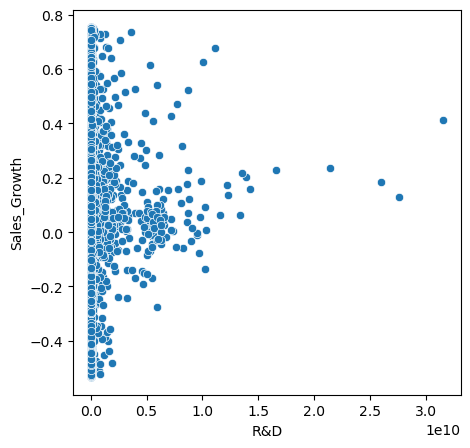

In [78]:
# Figure Size
plt.figure(figsize=(5,5))
# Make a scatter plot
sns.scatterplot(x='R&D', y='Sales_Growth', data=data_6)
# Print graph
plt.show()

Notes: Try Random forest. results are not linear

 ##### Random Forest Regressor

In [79]:
# Make copy to prevent error
data_rnd = data_6.copy()

In [80]:
# Define features and targets to predict if current sales growth
X = data_rnd[['R&D']]
y = data_rnd['Sales_Growth']

In [81]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Allow random forest
rf_model = RandomForestRegressor(random_state=42)

In [83]:
# Fit model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [84]:
# Predict model
y_pred_rf = rf_model.predict(X_test)

In [85]:
print("Random Forest - Just R&D")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest - Just R&D
MAE: 0.17938521606934457
RMSE: 0.24379403011469852
R2: -0.14660651810241654


In [86]:
# Define features and targets to predict if current sales growth
# include year to account for covid and industry due
X = pd.get_dummies(data_rnd[['R&D', 'Year', 'SIC_Industry']])
y = data_rnd['Sales_Growth']

In [87]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Allow random forest
rf_model = RandomForestRegressor(random_state=42)

In [89]:
# Fit model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [90]:
# Predict model
y_pred_rf = rf_model.predict(X_test)

In [91]:
print("Random Forest - R&D, Year, SIC_Industry")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest - R&D, Year, SIC_Industry
MAE: 0.17195655936782756
RMSE: 0.23592773312431617
R2: -0.07380707898508865


Not a good model. Try robust scaler for R&D and sales growth to decrease skew

In [92]:
# Copy of data for scaled data
data_7 = data_6.copy()

In [93]:
# Allow scaler
scaler = RobustScaler()

In [94]:
# Scale R&D and sales growth
data_7['R&D_scaled'] = scaler.fit_transform(data_7[['R&D']])
data_7['Sales_Growth_scaled'] = scaler.fit_transform(data_7[['Sales_Growth']])

In [95]:
# Define features and targets to predict
X = pd.get_dummies(data_7[['R&D_scaled', 'Year', 'SIC_Industry']])
y = data_7['Sales_Growth_scaled']

In [96]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# Fit model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [98]:
# Predict model
y_pred_rf = rf_model.predict(X_test)

In [99]:
print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 0.7889727774941492
RMSE: 1.0823998824044687
R2: -0.07409373014835174


Model is even worse. Only look at the top three

In [100]:
# Top three sales growth
keep = ['Agriculture, Forestry, and Fishing','Manufacturing','Services']

In [101]:
# New data set of only top three
data_8 = data_7[data_7['SIC_Industry'].isin(keep)]

In [102]:
# Make copy to prevent error
data_rnd_top3 = data_8.copy()

In [103]:
# Define features and targets to predict
X = data_rnd_top3[['R&D']]
y = data_rnd_top3['Sales_Growth']

In [104]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# Fit model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [106]:
# Predict model
y_pred_rf = rf_model.predict(X_test)

In [107]:
# Notes: Top three
print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 0.20082430858107664
RMSE: 0.26717961741934854
RMSE: 0.26717961741934854
R2: -0.26690272925426783


Try a different model

Random Forest - Only looking at R&D as Indep.
MAE: 0.21793900803113708
RMSE: 0.28644902589828736
RMSE: 0.28644902589828736
R2: -0.23215625461103118


Random Forest - Three indep. varb
MAE: 0.2049755338401916
RMSE: 0.27509560160027885
R2: -0.1364187217596715

##### Gradient Boosting

In [108]:
# Define features and targets to predict 
X = data_7[['R&D']]
y = data_7['Sales_Growth']

In [109]:
# Allow Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

In [110]:
# Fit the model
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [111]:
# Predict
y_pred_gb = gb_model.predict(X_test)

In [112]:
print("Gradient Boosting - R&D")
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R2:", r2_score(y_test, y_pred_gb))

Gradient Boosting - R&D
MAE: 0.1744392410753404
RMSE: 0.23761498243274928
RMSE: 0.23761498243274928
R2: -0.0020381726323932536


In [113]:
# Define features and targets to predict 
X = pd.get_dummies(data_rnd[['R&D', 'Year', 'SIC_Industry']])
y = data_rnd['Sales_Growth']

In [114]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
# Fit the model
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [116]:
# Predict
y_pred_gb = gb_model.predict(X_test)

In [117]:
print("Gradient Boosting - Top Three with Sales Growth")
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R2:", r2_score(y_test, y_pred_gb))

Gradient Boosting - Top Three with Sales Growth
MAE: 0.16037748633941384
RMSE: 0.22103317665731495
RMSE: 0.22103317665731495
R2: 0.057495996500312674


Notes: Model is better. Look at Inustry and Year

In [118]:
# Define features and targets to predict. Look at all
X = pd.get_dummies(data_7[['R&D', 'Year', 'SIC_Industry']])
y = data_7['Sales_Growth']

In [119]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
# Fit model
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [121]:
# Predict
y_pred_gb = gb_model.predict(X_test)

In [122]:
print("Gradient Boosting - All Industry")
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R2:", r2_score(y_test, y_pred_gb))

Gradient Boosting - All Industry
MAE: 0.16037748633941384
RMSE: 0.22103317665731495
RMSE: 0.22103317665731495
R2: 0.057495996500312674


Model is the same. Does not look like it made any difference to look at the top three or all of them.

R&D, year, and industry only explained a small amount of variation in sales growth

#### Actual Sales Growth Vs. Predicted

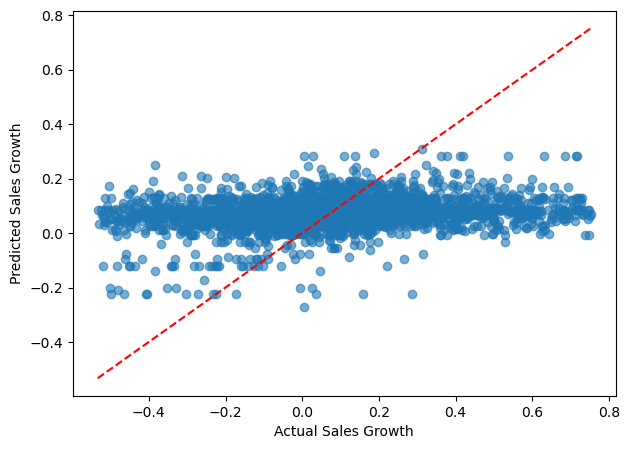

In [123]:
# Figure size
plt.figure(figsize=(7, 5))
# Make scatter plot
plt.scatter(y_test, y_pred_gb, alpha=0.6)
# X-label
plt.xlabel('Actual Sales Growth')
# Y-label
plt.ylabel('Predicted Sales Growth')
# Plot graph
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
# Print graph
plt.show()

#### Test Set Actual vs Predicted Sales Growth - Scatterplot

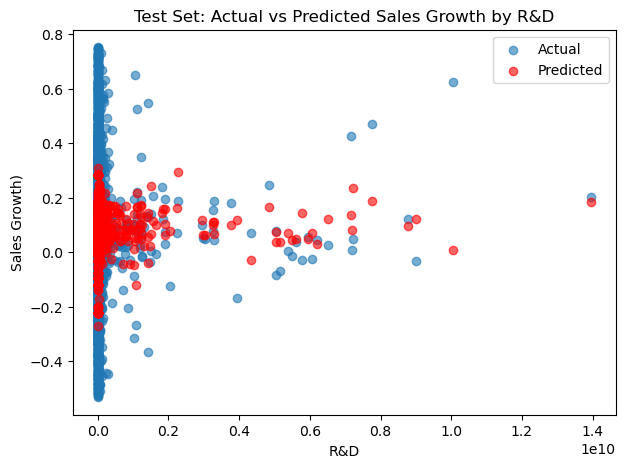

In [124]:
# Figure size
plt.figure(figsize=(7, 5))
# Scatterplot of Actual Data
plt.scatter(X_test['R&D'], y_test, label='Actual', alpha=0.6)
#Scatterplot of Predicted data
plt.scatter(X_test['R&D'], y_pred_gb, label='Predicted', alpha=0.6, color='red')
# X- Label
plt.xlabel('R&D')
#Y-Label
plt.ylabel('Sales Growth)')
# Titel
plt.title('Test Set: Actual vs Predicted Sales Growth by R&D')
#Key
plt.legend()
#Print Graph
plt.show()

### When a company increases its R&D spending in one year, does its sales growth accelerate in the subsequent year?

Notes: Not enough data per company for AIRMA. Use OLS

In [125]:
#Make copy of data
data_9 = data_8.copy()

In [126]:
# Group by Company ID and R&D. Shift one year
data_9['R&D'] = data_9.groupby('Company_ID')['R&D'].shift(1)

In [127]:
# Drop Na
data_9 = data_9[['Revenue', 'R&D', 'SIC_Industry']].dropna()

In [128]:
# Revenue ~ Prior year R&D
# Independ. Varb.
X = data_9[['R&D']]
# Add intercept
X = sm.add_constant(X)
# Depend. Varb.
y = data_9['Revenue']

In [129]:
# Fit Model
model = sm.OLS(y, X).fit()

In [130]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2128.
Date:                Sun, 13 Jul 2025   Prob (F-statistic):               0.00
Time:                        17:58:32   Log-Likelihood:            -1.7714e+05
No. Observations:                7061   AIC:                         3.543e+05
Df Residuals:                    7059   BIC:                         3.543e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.279e+09    2.3e+08     14.251      0.0

Notes:
- R&D coefficient = 10.15 | significant because p value is also p < .001
- R²= 0.274 | means 27.4% of revenue variation explained by prior year’s R&D
- Each 1 million increase in prior year’s R&D spending is associated with an average increase of about 10.15 million in revenue the following year.
- The relationship is statistically significant (p < 0.001), suggesting a real effect.
- R² = 0.27: Prior year R&D explains a portion of future revenue, but there are still many other factors.

### Classify companies into distinct groups, e.g., high investors, moderate investors, and low investors, based on their R&D spending and sales growth patterns.

In [131]:
# Group companies by mean R&D and Sales Growth
data_k = data_8.groupby('Company_ID').agg({'R&D': 'mean', 
                                         'Sales_Growth': 'mean'}).dropna()

In [132]:
# Scale, fit and transform the 
X_optK = StandardScaler().fit_transform(data_k[['R&D', 'Sales_Growth']])

In [133]:
# Empty list for k clusters
k_clus = []

##### Elbow Graph - Find K-Cluster

In [134]:
# Find Optimal Clster
for k in range(1, 10):
    # For each cluster fit a Kmeans model
    km = KMeans(n_clusters=k, random_state=42).fit(X_optK)
    # Append list
    k_clus.append(km.inertia_)

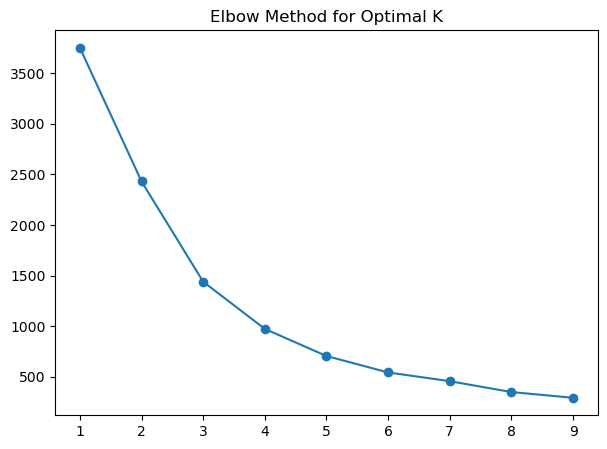

In [135]:
# Figure size
plt.figure(figsize=(7, 5))
# Plot the k clusters and mark each one
plt.plot(range(1,10), k_clus, marker='o')
# Title
plt.title('Elbow Method for Optimal K')
# Print Graph
plt.show()

In [136]:
# Allow KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)

In [137]:
# Data clusters to data table
data_k['Cluster'] = kmeans.fit_predict(data_k[['R&D', 'Sales_Growth']])

In [138]:
data_k.head(5)

,R&D,Sales_Growth,Cluster
Company_ID,,,
1000230,0.000000e+00,0.181119,0
1000694,2.664886e+08,0.210241,0
1001115,1.498288e+07,0.062616,0
1001233,4.702140e+07,-0.219903,0
1001907,3.301600e+06,0.049600,0


In [139]:
data_k['Cluster'].unique()

array([0, 2, 1, 3], dtype=int32)

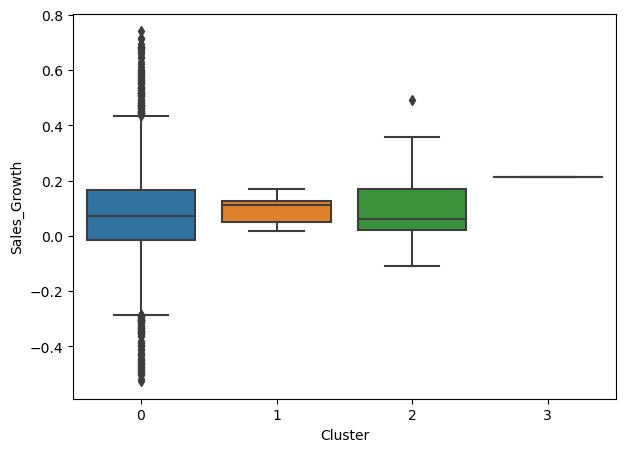

In [140]:
# Figure size
plt.figure(figsize=(7, 5))
# Make a box blot of the clusters (Sales Growth)
sns.boxplot(x='Cluster', y='Sales_Growth', data=data_k)
# Print graph
plt.show()

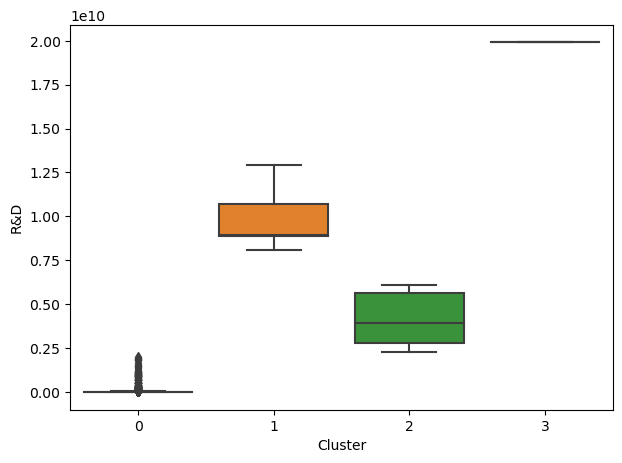

In [141]:
# Figure size
plt.figure(figsize=(7, 5))
# Make a box blot of the clusters (R&D)
sns.boxplot(x='Cluster', y='R&D', data=data_k)
# Print Graph
plt.show()

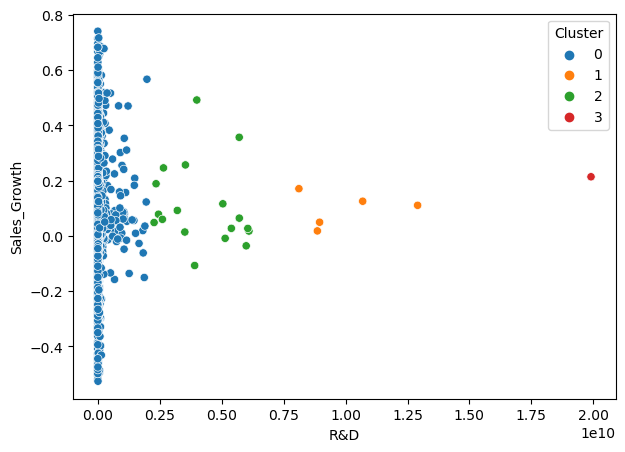

In [142]:
# Figure size
plt.figure(figsize=(7, 5))
# Scatter Plot of all the clusters
sns.scatterplot(x='R&D', y='Sales_Growth', hue='Cluster', data=data_k, palette='tab10')
# Print Graph
plt.show()